**We want to predict the economic impact of climate change**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# load dataset
df = pd.read_csv("DATA/global_climate_events_economic_impact_2020_2025.csv")
df.columns = df.columns.str.strip()

In [4]:
# feature selection and preprocessing
print("Columns in dataset:")
print(df.columns.tolist())

features = [
    'country', 
    'event_type', 
    'severity', 
    'duration_days', 
    'affected_population', 
    'infrastructure_damage_score', 
    'response_time_hours',
    'international_aid_received_million_usd', 
    'impact_per_capita',
    'total_casualties'
]

target = 'economic_impact_million_usd'

existing_features = [col for col in features if col in df.columns]

# drop rows with missing values in selected features and target
df = df.dropna(subset=existing_features + [target])

categorical_features = ['country', 'event_type']
numerical_features = [col for col in existing_features if col not in categorical_features]

print(df.columns)

Columns in dataset:
['event_id', 'date', 'year', 'month', 'country', 'event_type', 'severity', 'duration_days', 'affected_population', 'deaths', 'injuries', 'economic_impact_million_usd', 'infrastructure_damage_score', 'response_time_hours', 'international_aid_million_usd', 'latitude', 'longitude', 'total_casualties', 'impact_per_capita', 'aid_percentage']
Index(['event_id', 'date', 'year', 'month', 'country', 'event_type',
       'severity', 'duration_days', 'affected_population', 'deaths',
       'injuries', 'economic_impact_million_usd',
       'infrastructure_damage_score', 'response_time_hours',
       'international_aid_million_usd', 'latitude', 'longitude',
       'total_casualties', 'impact_per_capita', 'aid_percentage'],
      dtype='object')


In [5]:
# category feature encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [6]:
# prepare data for modeling
X = df[existing_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build pipeline with preprocessing and xgboost model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# fit model and evaluate
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Results: ")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f} million USD") 


Model Results: 
R²: 0.581
RMSE: 20.26 million USD


**Results**
*XGBoost model explains about 53% of the variance in economic impact, with an average prediction error of 21.49 million USD.*

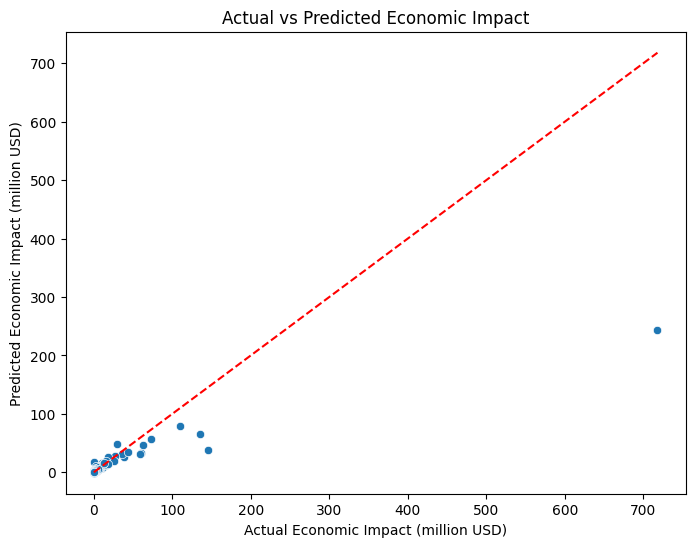

In [7]:
# visualization of actual vs predicted economic impact
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Economic Impact (million USD)')
plt.ylabel('Predicted Economic Impact (million USD)')
plt.title('Actual vs Predicted Economic Impact')
plt.show()

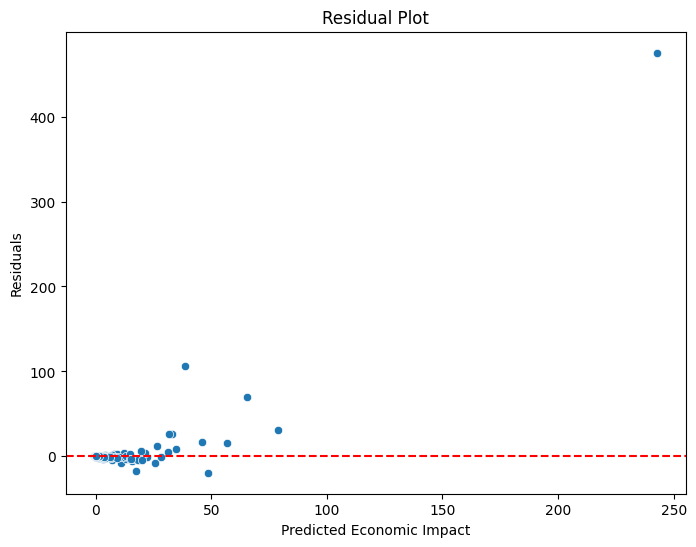

In [8]:
# residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Economic Impact')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

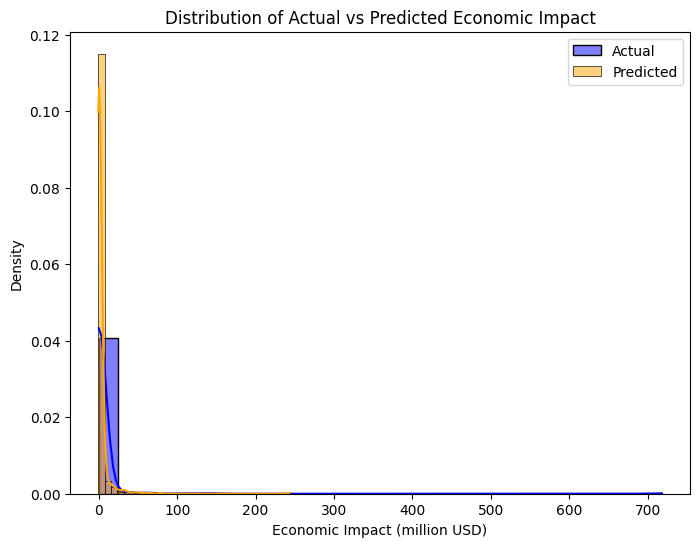

In [9]:
# distribution of perdictions vs actuals
plt.figure(figsize=(8, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True, stat="density", bins=30)
sns.histplot(y_pred, color='orange', label='Predicted', kde=True, stat="density", bins=30)
plt.xlabel('Economic Impact (million USD)')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Economic Impact')
plt.legend()
plt.show()